# Class Preprocessiong

# Code

In [22]:
from ps_estimator import pstimator 
import bandpowers
import utils

In [2]:
import numpy as np
import pymaster as nmt
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt 

import camb

from astropy.io import fits as fits

from scipy.linalg import sqrtm

from numpy import linalg as LA
%matplotlib inline

In [3]:
nside = 128
nmtlmax = 201
lmin = 2
lmax = 1521

In [20]:
b = nmt.NmtBin(nside, nlb=20, is_Dell=True, lmax=nmtlmax)
leff = b.get_effective_ells()
lbin = len(leff)
b_ind = np.arange(1,lbin+1)

## window function

 equal weight for each $\ell$ in a $\ell$-bin
 
 for bin_width = 20, weight = 1/20 = 0.05

### code

In [45]:
b = nmt.NmtBin(nside, nlb=20, is_Dell=True, lmax=nmtlmax)
leff = b.get_effective_ells()
nb = len(leff)
for i in range(nb):

    bpwf = np.zeros(lmax-lmin+2)
    lrange = b.get_ell_list(i)
    w = b.get_weight_list(i) ## weights for each ell in i-th bin
    bpwf[lrange-lmin+1] = w
    l = np.arange(1, lmax-lmin+3)

    bpwf = np.array([l, bpwf]).T
    
    # print(np.shape(bpwf))
    # np.savetxt(data_dir+'AliCPT_bpwf_bin%s.txt'%(i+1), bpwf, fmt=['%d', '%.10e', '%.10e', '%.10e'])
    # np.savetxt(data_dir + 'AliCPT_bpwf_bin%s.txt' % (i + 1), bpwf, fmt=['%d', '%.10e', '%.10e', '%.10e', '%.10e', '%.10e', '%.10e'])
#     np.savetxt(data_dir+'AliCPT_bpwf_bin%s.txt'%(i+1), bpwf, fmt=['%d', '%.10e'])

##  $C_{\ell}^b$ : fiducial bandpower for each $\ell$-bin, using Window function. or theoretical ?? 

Liu Yang's code 把由camb生成的理论功率谱当做fiducial power spectra, 如何得到 Bicep's $C_{f, \ell}$



> cl_fiducial_file = AliCPT_fiducial.dat

39x1, assuing cross power spectra for different frequencies are the same 

cl_diducial_order = Ali_95_BxAli_95_B Ali_95_BxAli_150_B Ali_95_BxAli_353_B Ali_150_BxAli_150_B Ali_150_BxAli_353_B Ali_353_BxAli_353_B

## $\hat {C}_{\ell} $ : observed data.

> AliCPT_cl_hat.dat

cl_hat_file = AliCPT_cl_hat.dat 

39x7 (first line is \ell bin, what remain are cross bandpowers bwtween frequencies)

cl_hat_order = Ali_95_BxAli_95_B Ali_95_BxAli_150_B Ali_95_BxAli_353_B Ali_150_BxAli_150_B Ali_150_BxAli_353_B Ali_353_BxAli_353_B

### Mask, foreground and total map

In [12]:
ali_ma = hp.read_map('/fnx/jianyao/Likelihood_data/ABSData/ali_mask.fits', field = None)
# mask = nmt.mask_apodization(ali_ma,  6, apotype='C2')
# hp.mollview(mask, title='Apodized mask')

NSIDE = 128
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


In [5]:
## loading foreground

fore_names = ['/fnx/jianyao/Likelihood_data/ABSData/pysm_s1d1_30.fits', '/fnx/jianyao/Likelihood_data/ABSData/pysm_s1d1_95.fits', 
              '/fnx/jianyao/Likelihood_data/ABSData/pysm_s1d1_150.fits', '/fnx/jianyao/Likelihood_data/ABSData/pysm_s1d1_353.fits' ]

fore30 = hp.read_map(fore_names[0], field = None);fore95 = hp.read_map(fore_names[1], field = None)
fore150 = hp.read_map(fore_names[2], field = None);fore353 = hp.read_map(fore_names[2], field = None)

NSIDE = 128
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 128
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 128
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 128
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


In [6]:
n30 = np.load('/fnx/jianyao/Likelihood_data/Noises/Noise_realizations_30GHz.npy');
n95 = np.load('/fnx/jianyao/Likelihood_data/Noises/Noise_realizations_95GHz.npy');
n150 = np.load('/fnx/jianyao/Likelihood_data/Noises/Noise_realizations_150GHz.npy');
n353 = np.load('/fnx/jianyao/Likelihood_data/Noises/Noise_realizations_353GHz.npy')

cmb = np.load('/fnx/jianyao/Likelihood_data/cmb_maps.npy')

In [8]:
n30.shape

(20, 3, 196608)

In [7]:
SamNum = 20

In [13]:
est = bandpowers.BPE(mask_in = ali_ma, nside = 128, bin_w = 20, lmax = nmtlmax)

In [14]:
beam_low = 19; Nf = 4

total = np.zeros((Nf, 2, 12*nside**2)); cl_hat_all = np.zeros((SamNum, 3,est.lbin, Nf, Nf))

for n in range(SamNum):
    ''' mark '''
    cmb_i = cmb[n]; 
    
    ################ without beam first
    
    total[0] = (cmb[n] + fore30 + n30[n])[1:];  ## only QU map for Jiaxin's code
    total[1] = (cmb[n] + fore95 + n95[n])[1:];
    total[2] = (cmb[n] + fore150 + n150[n])[1:]; 
    total[3] = (cmb[n] + fore353 + n353[n])[1:]; 
    
    cl_hat_all[n] = est.Cross_EB(total)## EE EB BB-mode 
    
    
    ################ considering beam
    
#     total[0] = deconv(smooth(cmb_i + fore, beam_out = 32, lmax = lmax + 100) + noise_30, beam_in = 32, beam_out = beam_low,lmax = lmax+100)
    
#     total[1] = smooth(cmb_i, beam_out = 19, lmax = lmax + 100) + fore95 + noise_95 #(, beam_in = 19, beam_out = beam_low, lmax = lmax + 100) + noise_95
    
#     total[2] = deconv(smooth(cmb_i, beam_out=11, lmax = lmax + 100) + fore150 + noise_150, beam_in = 11, beam_out = beam_low, lmax = lmax + 100) #+ noise_150
#     total[3] = deconv(smooth(cmb_i, beam_out=4.944, lmax = lmax + 100) + fore353 + noise_353 , beam_in = 4.944, beam_out = beam_low, lmax = lmax + 100) #+ noise_353
    
    #################
    
## downgrade to the same resolution then calculate the bandpowers ??

In [15]:
cl_hat_all.shape

(20, 3, 10, 4, 4)

In [16]:
cl_hat = np.mean(cl_hat_all, axis = 0)

In [17]:
cl_hat.shape

(3, 10, 4, 4)

In [18]:
total.shape

(4, 2, 196608)

In [732]:
e, E = LA.eig(cl_th[5])

In [734]:
np.real(sqrtm(LA.pinv(cl_th[5])))

array([[1.47347455, 1.47347454, 1.47347455, 1.47347455],
       [1.47347455, 1.47347457, 1.47347454, 1.47347454],
       [1.47347455, 1.47347454, 1.47347455, 1.47347455],
       [1.47347455, 1.47347454, 1.47347455, 1.47347455]])

In [693]:
utils.calc_vecp(1, cl_hat[0], cl_f, cl_th)

Failed to find a square root.


/home/jianyao/Likelihood/utils.py:28: RuntimeWarning: invalid value encountered in log
  gd = np.sign(np.diag(d) - 1) * np.sqrt(2 * (np.diag(d) - np.log(np.diag(d)) - 1))
/home/jianyao/Likelihood/utils.py:54: ComplexWarning: Casting complex values to real discards the imaginary part
  vec[counter:counter+dim-iDiag] = np.diag(mat,iDiag)


array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

### Integrage BICEP's code

In [408]:
utils.vecp(cl_hat[0])

array([ 1.00829794e+02,  1.02737541e-01,  5.10595704e-01,  7.10845956e+02,
       -2.91668135e-01,  2.24426413e-01, -1.57183722e-01, -7.60839587e-01,
       -4.07421217e-02, -5.22125559e+00])

### calculate the bandpowers

#### Own

## Bandpower covariance matrix

10 bins, 10-fre cross, SamNum BB

> /home/yao/Desktop/likelihood/ali_joint_analysis/CosmoMC_AliCPT/data/AliCPT_Plk/AliCPT_covmat.dat

$234 \times 234$

(39x6) * (39x6)

39-bin; bin_width = 20, nmtlmax = 800 

Ali_95_BxAli_95_B Ali_95_BxAli_150_B Ali_95_BxAli_353_B Ali_150_BxAli_150_B Ali_150_BxAli_353_B Ali_353_BxAli_353_B

### Get arrays for Covariance matrix

In [23]:
nf_ind = int(Nf*(Nf + 1)/2)

marray = np.zeros(((3*lbin*nf_ind), SamNum)) # mode(EE, EB, BB), l-bin, nf independent corr between frequencies 
for n in range(SamNum):
    
    for mode in range(3):
        
    
        cl_flat = np.zeros((lbin, nf_ind)) ## collect independent corr for each l-bin

        for ell in range(lbin):
            cl_flat[ell] = utils.vecp(cl_hat_all[n][mode][ell])

        marray[mode*lbin*nf_ind:(mode+1)*lbin*nf_ind,n] = cl_flat.flatten()

In [24]:
cov_mat_BB = np.corrcoef(marray[200:])
# np.cov(marray)

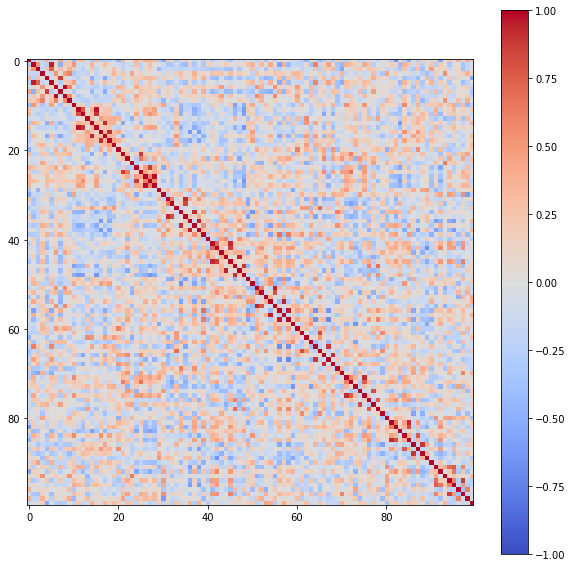

In [25]:
plt.figure(figsize = (10,10))
plt.imshow(cov_mat_BB, cmap = 'coolwarm', vmin = -1, vmax = 1)
plt.colorbar()

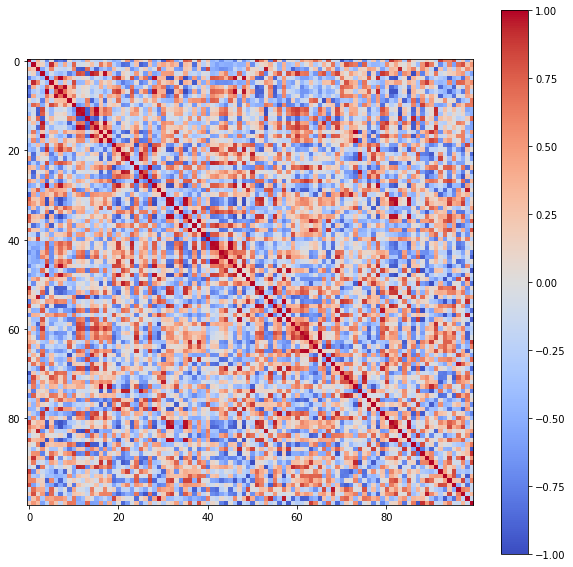

In [725]:
plt.figure(figsize = (10,10))
plt.imshow(cov_mat_BB, cmap = 'coolwarm', vmin = -1, vmax = 1)
plt.colorbar()

In [722]:
cov_mat =  np.corrcoef(marray)## full covariance matrix
# 
# np.corrcoef(marray)

Text(12, 320, '$\\ell$2')

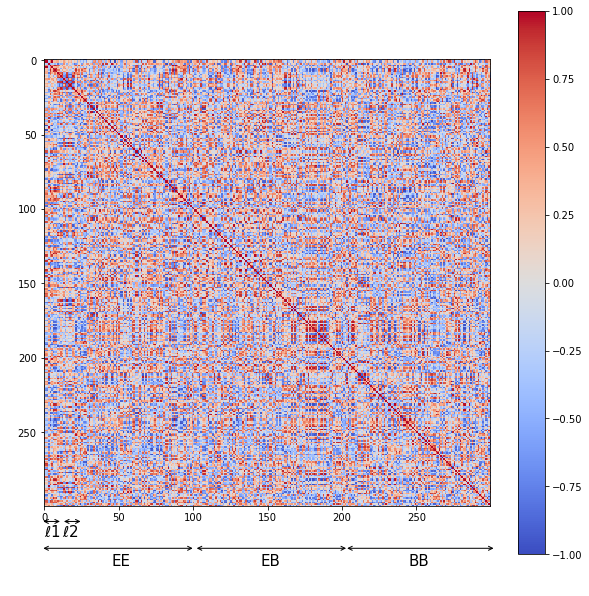

In [723]:
plt.figure(figsize = (10,10))
plt.imshow(cov_mat, cmap = 'coolwarm', vmin = -1, vmax = 1)
plt.colorbar()
# plt.text(0,-5,'EE')
# plt.xticks([100], 'hh')
# plt.xlim(-10, 310)
# plt.ylim(-10, 310)

plt.annotate(s = '',xy=(0.07,0.08), xytext=(0.33,0.08),arrowprops=dict(arrowstyle='<->'), xycoords = 'figure fraction')
plt.annotate(s = '',xy=(0.33,0.08), xytext=(0.59,0.08),arrowprops=dict(arrowstyle='<->'), xycoords = 'figure fraction')
plt.annotate(s = '',xy=(0.585,0.08), xytext=(0.84,0.08),arrowprops=dict(arrowstyle='<->'), xycoords = 'figure fraction')
plt.text(45, 340, 'EE', fontsize = '15')
plt.text(145, 340, 'EB', fontsize = '15')
plt.text(245, 340, 'BB', fontsize = '15')

plt.annotate(s = '',xy=(0.07,0.125), xytext=(0.105,0.125),arrowprops=dict(arrowstyle='<->'), xycoords = 'figure fraction')
plt.annotate(s = '',xy=(0.105,0.125), xytext=(0.140,0.125),arrowprops=dict(arrowstyle='<->'), xycoords = 'figure fraction')

plt.text(0, 320, '$\ell$1', fontsize = '15')
plt.text(12, 320, '$\ell$2', fontsize = '15')

In [702]:
cov_mat_BB.shape

(100, 100)

### reorganize M

In [720]:
M = np.ones((lbin, lbin, nf_ind, nf_ind))
for ell in range(lbin*nf_ind):
    i = ell//10; j = ell%10;
    for fre in range(nf_ind):
        
        M[i, j] = np.triu(cov_mat_BB[ell, nf_ind*fre:nf_ind*(fre+1)])
        
M_inv = LA.inv(M) ## only BB

### Likelihood

In [721]:
utils.evaluateLikelihood(cl_th, cl_hat[2], cl_f, M_inv)

Failed to find a square root.
Failed to find a square root.
Failed to find a square root.


/home/jianyao/Likelihood/utils.py:28: RuntimeWarning: invalid value encountered in log
  gd = np.sign(np.diag(d) - 1) * np.sqrt(2 * (np.diag(d) - np.log(np.diag(d)) - 1))
/home/jianyao/Likelihood/utils.py:54: ComplexWarning: Casting complex values to real discards the imaginary part
  vec[counter:counter+dim-iDiag] = np.diag(mat,iDiag)


LinAlgError: Eigenvalues did not converge

#### Jiaxin's implementation

In [359]:
estj = ps_estimator.pstimator(nside = 128, mask=ali_ma.reshape(1, -1), aposcale=6, psbin=20, lmax=200)

In [381]:
# %%timeit

bpsj = estj.cross_eb(np.r_[total[0], total[1]])